In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


# **Gaussian example**

This a basic example of gaussian DDPM, using the closed form for backward gaussian pocess.

In [ ]:
mu0 = np.array([1.0, -1.0])
Sigma0 = 0.2 * np.eye(2)

N = 3000
x0 = np.random.multivariate_normal(mu0, Sigma0, size=N)


In [ ]:
class GaussianDDPM:
    def __init__(self, betas, mu0, Sigma0):
        self.betas = betas
        self.alphas = 1.0 - betas
        self.mu0 = mu0
        self.Sigma0 = Sigma0

        self.mus = [mu0]
        self.Sigmas = [Sigma0]

        for a, b in zip(self.alphas, self.betas):
            mu_next = np.sqrt(a) * self.mus[-1]
            Sigma_next = a * self.Sigmas[-1] + b * np.eye(2)
            self.mus.append(mu_next)
            self.Sigmas.append(Sigma_next)

    def forward(self, x0):
        xs = [x0]
        x = x0
        for a, b in zip(self.alphas, self.betas):
            noise = np.random.randn(*x.shape)
            x = np.sqrt(a) * x + np.sqrt(b) * noise
            xs.append(x)
        return xs

    def backward(self, xT):
        x = xT
        xs = [x]

        for t in reversed(range(len(self.betas))):
            a = self.alphas[t]
            b = self.betas[t]

            mu_prev = self.mus[t]
            Sigma_prev = self.Sigmas[t]

            # posterior covariance
            Sigma_post = np.linalg.inv(
                (a / b) * np.eye(2) + np.linalg.inv(Sigma_prev)
            )

            # posterior mean
            mean = (
                Sigma_post @
                ((np.sqrt(a) / b) * x.T +
                 np.linalg.inv(Sigma_prev) @ mu_prev[:, None])
            ).T

            x = mean + np.random.multivariate_normal(
                np.zeros(2), Sigma_post, size=len(x)
            )
            xs.append(x)

        return xs[::-1]

## **Running the model**

In [2]:
T = 100
betas = np.linspace(1e-4, 0.01, T)

ddpm = GaussianDDPM(betas, mu0, Sigma0)

forward = ddpm.forward(x0)
backward = ddpm.backward(forward[-1])


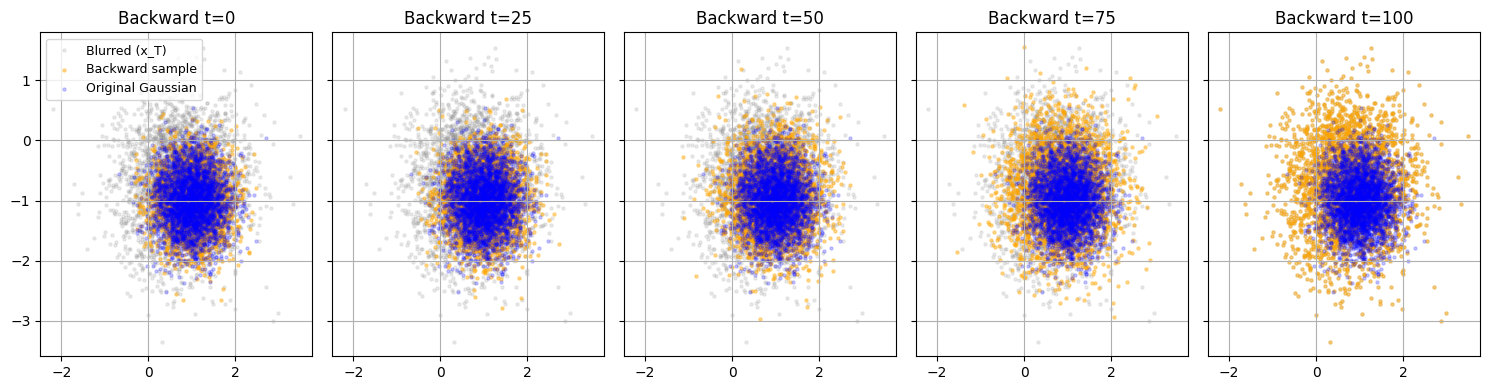

In [8]:
steps = [0, 25, 50, 75, 100]

x_orig = x0            
x_blur = forward[-1]    

fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharex=True, sharey=True)

for i, s in enumerate(steps):
    ax[i].scatter(
        x_blur[:, 0], x_blur[:, 1],
        s=5, alpha=0.15, color="gray", label="Blurred (x_T)" if i == 0 else None
    )

    ax[i].scatter(
        backward[s][:, 0], backward[s][:, 1],
        s=5, alpha=0.4, color="orange", label="Backward sample" if i == 0 else None
    )

    ax[i].scatter(
        x_orig[:, 0], x_orig[:, 1],
        s=5, alpha=0.2, color="blue", label="Original Gaussian" if i == 0 else None
    )

    ax[i].set_title(f"Backward t={s}")
    ax[i].grid()

ax[0].legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()
